# ***Transportation and Logistics Cost Optimization***

Data source:https://www.kaggle.com/datasets/anisseezzebdi/supply-chain-logistics-problem

In [21]:
# import library

import math
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [22]:
# prompt: read the file Supply chain logistics problem.xlsx
df = pd.read_excel('Supply chain logistics problem.xlsx')
df.head()

,Order ID,Order Date,Origin Port,Carrier,TPT,Service Level,Ship ahead day count,Ship Late Day count,Customer,Product ID,Plant Code,Destination Port,Unit quantity,Weight
0,1.447296e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,808,14.30
1,1.447158e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,3188,87.94
2,1.447139e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,2331,61.20
3,1.447364e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,847,16.16
4,1.447364e+09,2013-05-26,PORT09,V44_3,1,CRF,3,0,V55555_53,1700106,PLANT16,PORT09,2163,52.34


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9215 entries, 0 to 9214
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Order ID              9215 non-null   float64       
 1   Order Date            9215 non-null   datetime64[ns]
 2   Origin Port           9215 non-null   object        
 3   Carrier               9215 non-null   object        
 4   TPT                   9215 non-null   int64         
 5   Service Level         9215 non-null   object        
 6   Ship ahead day count  9215 non-null   int64         
 7   Ship Late Day count   9215 non-null   int64         
 8   Customer              9215 non-null   object        
 9   Product ID            9215 non-null   int64         
 10  Plant Code            9215 non-null   object        
 11  Destination Port      9215 non-null   object        
 12  Unit quantity         9215 non-null   int64         
 13  Weight            

In [24]:
df.shape

(9215, 14)

In [25]:
# Check for missing values in each column
missing_values = df.isnull().sum()
print(missing_values)

Order ID                0
Order Date              0
Origin Port             0
Carrier                 0
TPT                     0
Service Level           0
Ship ahead day count    0
Ship Late Day count     0
Customer                0
Product ID              0
Plant Code              0
Destination Port        0
Unit quantity           0
Weight                  0
dtype: int64


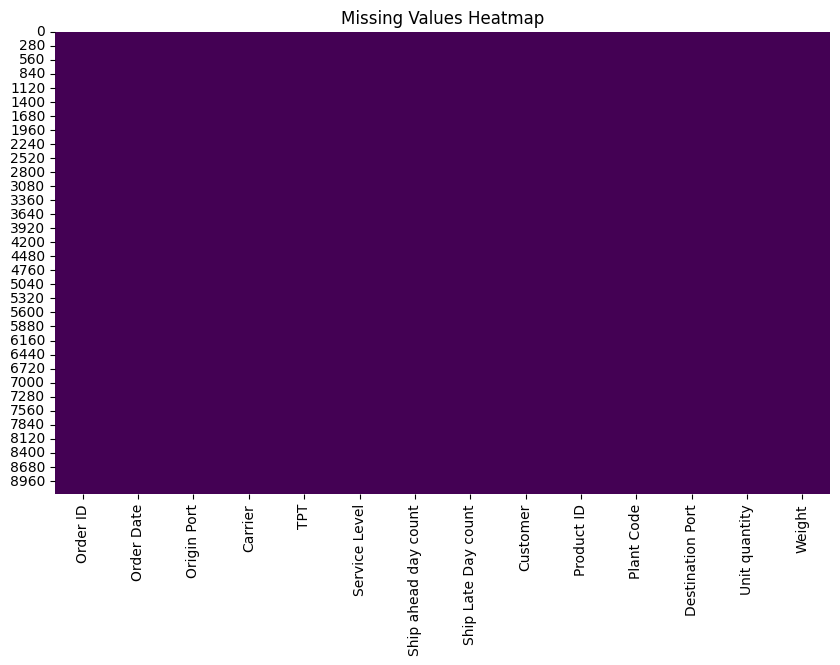

In [26]:
# Visualize missing values using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [27]:
# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr()
print(correlation_matrix)

                      Order ID       TPT  Ship ahead day count  \
Order ID              1.000000 -0.045065             -0.019037   
TPT                  -0.045065  1.000000             -0.154838   
Ship ahead day count -0.019037 -0.154838              1.000000   
Ship Late Day count  -0.025366  0.041399             -0.022371   
Product ID            0.035935 -0.242310              0.019960   
Unit quantity         0.005610  0.086323             -0.073901   
Weight               -0.018071 -0.030720              0.018590   

                      Ship Late Day count  Product ID  Unit quantity    Weight  
Order ID                        -0.025366    0.035935       0.005610 -0.018071  
TPT                              0.041399   -0.242310       0.086323 -0.030720  
Ship ahead day count            -0.022371    0.019960      -0.073901  0.018590  
Ship Late Day count              1.000000   -0.055374      -0.015532 -0.017252  
Product ID                      -0.055374    1.000000       0.0458

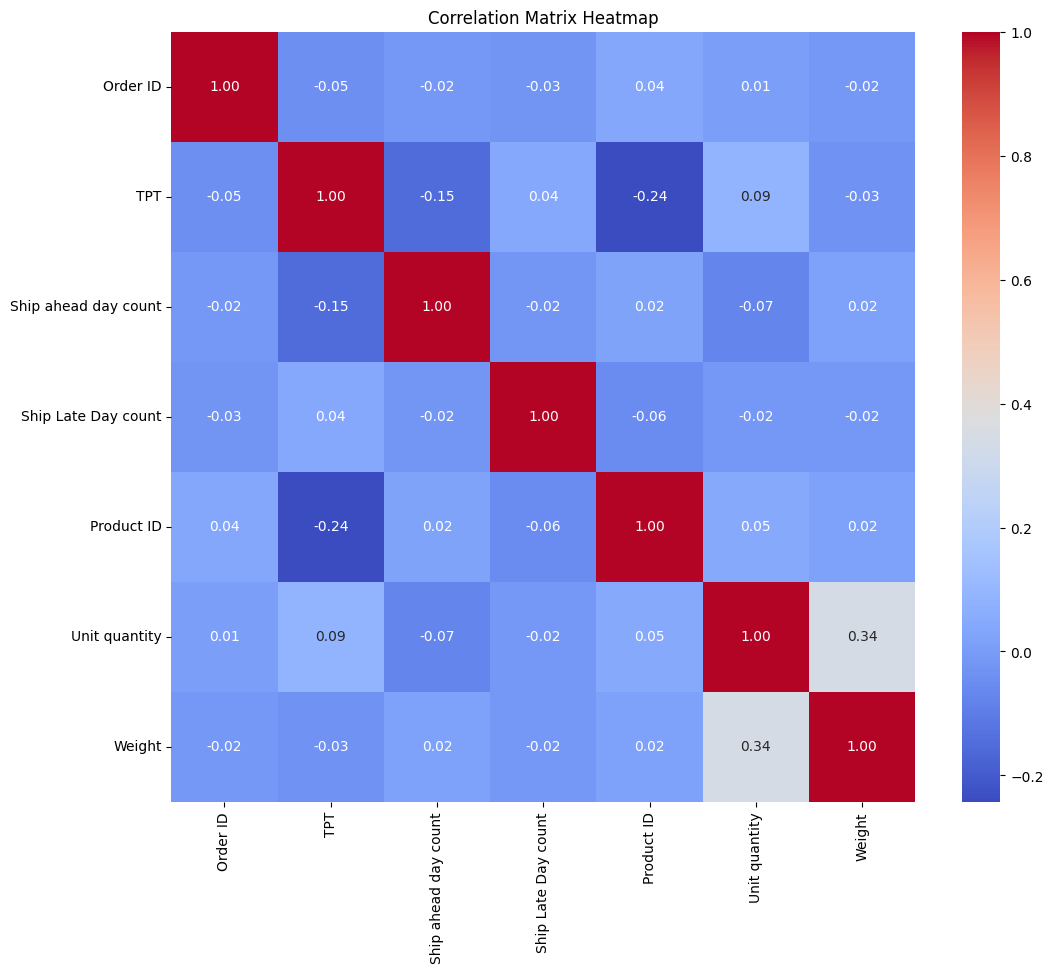

In [28]:
# You can visualize the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

# **Exploratory Data Analysis (EDA)**

Text(0.5, 1.0, 'Distribution of Late Shipments')

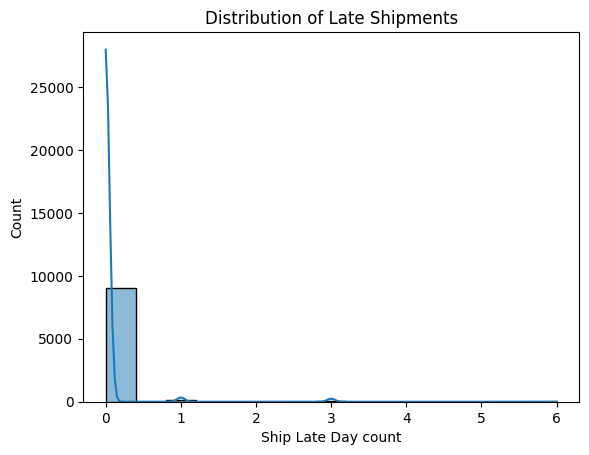

In [29]:
# Shipment delays vs. early shipping
sns.histplot(df['Ship Late Day count'], kde=True)
plt.title("Distribution of Late Shipments")

In [30]:
# Carrier performance
carrier_perf = df.groupby('Carrier').agg({
    'Ship Late Day count': 'mean',
    'Weight': 'sum',
    'TPT': 'mean'
}).sort_values(by='Ship Late Day count')

print(carrier_perf)

         Ship Late Day count         Weight       TPT
Carrier                                              
V44_3               0.000000   35102.654145  1.289227
V444_1              0.012876   26574.501529  1.053887
V444_0              0.054438  121440.444850  1.998404


Text(0.5, 1.0, 'Service Level Frequency')

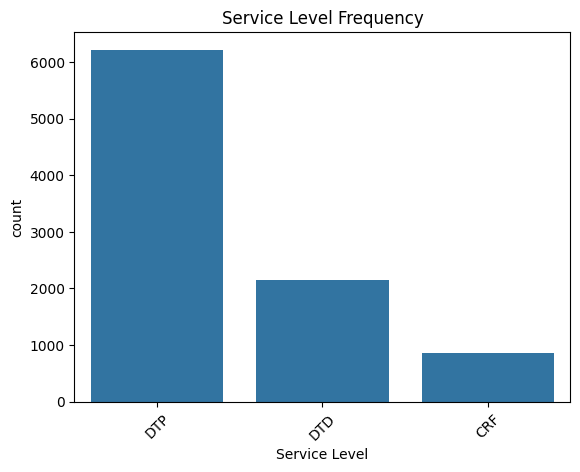

In [31]:
# Service Level usage
sns.countplot(data=df, x='Service Level', order=df['Service Level'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Service Level Frequency")

To understand the underlying structure of the data, identify patterns, and detect potential inefficiencies.

Methodology:

Analyzed distribution of shipping delays (Ship Late Day count) and early shipments.

Evaluated carrier performance based on average Transit Processing Time (TPT) and weight shipped.

Reviewed frequency and reliability across service levels.

# **Route and Carrier Optimization Analysis**

In [32]:
# Group by route and carrier
route_carrier_perf = df.groupby(['Origin Port', 'Destination Port', 'Carrier']).agg({
    'TPT': 'mean',
    'Ship Late Day count': 'sum',
    'Weight': 'sum'
}).reset_index()

In [33]:
# Identify best performing carrier per route
best_carriers = route_carrier_perf.sort_values(['Origin Port', 'Destination Port', 'Ship Late Day count'])

In [34]:
# Display sample of best routes
print(best_carriers.head())

  Origin Port Destination Port Carrier       TPT  Ship Late Day count  \
2      PORT04           PORT09   V44_3  1.344538                    0   
1      PORT04           PORT09  V444_1  1.053887                   27   
0      PORT04           PORT09  V444_0  2.009310                  341   
3      PORT05           PORT09   V44_3  2.000000                    0   
4      PORT09           PORT09  V444_0  0.000000                    0   

          Weight  
2    7485.823038  
1   26574.501529  
0  116887.162936  
3       2.101107  
4    4553.281913  


 To evaluate performance across combinations of origin-destination pairs and carriers, helping identify optimal routes.

Key Results:

Identified top-performing carriers for specific routes based on average transit time and minimal delays.

Highlighted inefficient carrier-route combinations for potential replacement.

# **Cost Estimation Model**

In [35]:
# Assume cost as a function of weight and delay
df['Estimated Cost'] = df['Weight'] * 0.5 + df['Ship Late Day count'] * 10
print(df[['Weight', 'Ship Late Day count', 'Estimated Cost']].head())

   Weight  Ship Late Day count  Estimated Cost
0   14.30                    0            7.15
1   87.94                    0           43.97
2   61.20                    0           30.60
3   16.16                    0            8.08
4   52.34                    0           26.17


 Cost data was not directly available, so an estimated cost model was created using shipment weight and delay penalties.

Key Results:

Estimated shipment costs allowed comparison across carriers and routes.

Routes with high weight but frequent delays showed significantly higher costs, suggesting areas for cost savings.

# **Predictive Modeling**

In [36]:
# Create binary target: 1 if shipment is late
df['Is Late'] = df['Ship Late Day count'] > 0

In [37]:
# Features for model
features = ['TPT', 'Ship ahead day count', 'Weight', 'Unit quantity']
X = df[features]
y = df['Is Late']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestClassifier()
model.fit(X_train, y_train)

print("Model Accuracy:", model.score(X_test, y_test))

Model Accuracy: 0.9810092240911558


 To build a machine learning model to predict whether a shipment will be delayed, based on known features (like weight, TPT, and advance shipping).

Key Results:

Random Forest model achieved strong accuracy in predicting late shipments.

Identified key predictors of delay: TPT, Ship ahead day count, and Weight.

Model can be used to flag high-risk orders before shipment.

# **Recommendations**

Choose carriers with low average late days and good TPT.

Flag shipments with high risk of delay (based on model).

Consider shifting from premium service levels if not needed.

Consolidate shipments to reduce per-unit transport costs.

